In [ ]:
import pandas as pd
import numpy as np
import statistics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Merge Datasets

In [ ]:
# import datasets
df1 = pd.read_csv('/content/drive/My Drive/CSM148/Project3/BrandAverageRetailPrice.csv')
df2 = pd.read_csv('/content/drive/My Drive/CSM148/Project3/BrandTotalUnits.csv')
df3 = pd.read_csv('/content/drive/My Drive/CSM148/Project3/BrandTotalSales.csv')
brand_details = pd.read_csv('/content/drive/My Drive/CSM148/Project3/BrandDetails.csv')

In [ ]:
# brand average retail price dataset
df1.head()

,Brands,Months,ARP,vs. Prior Period
0,#BlackSeries,08/2020,15.684913,NaN
1,#BlackSeries,09/2020,NaN,-1.000000
2,#BlackSeries,01/2021,13.611428,NaN
3,#BlackSeries,02/2021,11.873182,-0.127705
4,#BlackSeries,03/2021,NaN,-1.000000


In [ ]:
# brand total units dataset
df2.head()

,Brands,Months,Total Units,vs. Prior Period
0,#BlackSeries,08/2020,"1,616.3390040000000",NaN
1,#BlackSeries,09/2020,NaN,-1.000000
2,#BlackSeries,01/2021,715.5328380000000,NaN
3,#BlackSeries,02/2021,766.669135,0.071466
4,#BlackSeries,03/2021,NaN,-1.000000


In [ ]:
# brand total sales dataset
df3 = df3.rename(columns={'Brand': 'Brands'})
df3.head()

,Months,Brands,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"


In [ ]:
# combine the previous 3 datasets
brand_history = df1.merge(df2, on=['Months', 'Brands'], how='outer').merge(df3, on=['Months', 'Brands'], how='outer')
brand_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27686 entries, 0 to 27685
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brands              27686 non-null  object 
 1   Months              27686 non-null  object 
 2   ARP                 25279 non-null  float64
 3   vs. Prior Period_x  24499 non-null  float64
 4   Total Units         25712 non-null  object 
 5   vs. Prior Period_y  24935 non-null  float64
 6   Total Sales ($)     25279 non-null  object 
dtypes: float64(3), object(4)
memory usage: 1.7+ MB


In [ ]:
brand_history.head()

,Brands,Months,ARP,vs. Prior Period_x,Total Units,vs. Prior Period_y,Total Sales ($)
0,#BlackSeries,08/2020,15.684913,NaN,"1,616.3390040000000",NaN,"25,352.135918000000"
1,#BlackSeries,09/2020,NaN,-1.000000,NaN,-1.000000,NaN
2,#BlackSeries,01/2021,13.611428,NaN,715.5328380000000,NaN,"9,739.4234"
3,#BlackSeries,02/2021,11.873182,-0.127705,766.669135,0.071466,"9,102.802187000000"
4,#BlackSeries,03/2021,NaN,-1.000000,NaN,-1.000000,NaN


In [ ]:
# brand details dataset
pd.set_option('display.max_columns', None)
brand_details.head()

,State,Channel,Category L1,Category L2,Category L3,Category L4,Category L5,Brand,Product Description,Total Sales ($),Total Units,ARP,Flavor,Items Per Pack,Item Weight,Total THC,Total CBD,Contains CBD,Pax Filter,Strain,Is Flavored,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,California,Licensed,Inhaleables,Flower,Hybrid,NaN,NaN,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),"1,103.964857",85.86394100000000,12.857142,NaN,0,NaN,0,0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
1,California,Licensed,Inhaleables,Flower,Hybrid,NaN,NaN,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),674.645211,42.931971000000000,15.714285,NaN,0,NaN,0,0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
2,California,Licensed,Inhaleables,Flower,Sativa Dominant,NaN,NaN,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),"2,473.699102",157.417226,15.714285,NaN,0,NaN,0,0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
3,California,Licensed,Inhaleables,Flower,Sativa Dominant,NaN,NaN,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),"14,589.916417","1,195.9888350000000",12.199041,NaN,0,NaN,0,0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
4,California,Licensed,Inhaleables,Concentrates,Dabbable Concentrates,Wax,NaN,101 Cannabis Co.,101 Cannabis Co. - Afghan Kush - Wax,145.39627,4.088759,35.560000,NaN,0,NaN,0,0,THC Only,NaN,Afghan Kush,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99


In [ ]:
brand_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144977 entries, 0 to 144976
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   State                144977 non-null  object 
 1   Channel              144977 non-null  object 
 2   Category L1          144977 non-null  object 
 3   Category L2          144977 non-null  object 
 4   Category L3          144245 non-null  object 
 5   Category L4          102618 non-null  object 
 6   Category L5          50135 non-null   object 
 7   Brand                144977 non-null  object 
 8   Product Description  144977 non-null  object 
 9   Total Sales ($)      144977 non-null  object 
 10  Total Units          144977 non-null  object 
 11  ARP                  144977 non-null  float64
 12  Flavor               7807 non-null    object 
 13  Items Per Pack       144977 non-null  int64  
 14  Item Weight          64454 non-null   object 
 15  Total THC        

In [ ]:
# only include columns of interest
brand_details = brand_details[['Category L1','Brand', 'Total THC', 'Total CBD', 
                               'Contains CBD', 'Pax Filter', 'Mood Effect',
                               'Generic Vendor', 'Generic Items', '$5 Price Increment']]
brand_details.head()

,Category L1,Brand,Total THC,Total CBD,Contains CBD,Pax Filter,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,Inhaleables,#BlackSeries,0,0,THC Only,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
1,Inhaleables,#BlackSeries,0,0,THC Only,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
2,Inhaleables,#BlackSeries,0,0,THC Only,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
3,Inhaleables,#BlackSeries,0,0,THC Only,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
4,Inhaleables,101 Cannabis Co.,0,0,THC Only,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99


In [ ]:
# get list of unique values in each column for each brand
brand_details = brand_details.rename(columns={'Brand': 'Brands'})

brand_details_new = {}
for brand in brand_details['Brands'].unique():
  d = {}
  temp = brand_details[brand_details['Brands'] == brand]
  for col in brand_details.columns:
    if col != 'Brands':
      d[col] = temp[col].unique()
  brand_details_new[brand] = d
      
brand_details = pd.DataFrame(brand_details_new).transpose()

In [ ]:
# merge brand details with history dataframe
brand_details['Brands'] = brand_details.index
df = brand_history.merge(brand_details, on=['Brands'], how='outer')
df.head()

,Brands,Months,ARP,vs. Prior Period_x,Total Units,vs. Prior Period_y,Total Sales ($),Category L1,Total THC,Total CBD,Contains CBD,Pax Filter,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,#BlackSeries,08/2020,15.684913,NaN,"1,616.3390040000000",NaN,"25,352.135918000000",[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]"
1,#BlackSeries,09/2020,NaN,-1.000000,NaN,-1.000000,NaN,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]"
2,#BlackSeries,01/2021,13.611428,NaN,715.5328380000000,NaN,"9,739.4234",[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]"
3,#BlackSeries,02/2021,11.873182,-0.127705,766.669135,0.071466,"9,102.802187000000",[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]"
4,#BlackSeries,03/2021,NaN,-1.000000,NaN,-1.000000,NaN,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]"


In [ ]:
# format columns as desired
df['Months'] = pd.to_datetime(df['Months'])
df = df.dropna(subset=['ARP', 'Total Units', 'Total Sales ($)'], how='all')
df = df.dropna(thresh=9)

df['Total Sales ($)'] = df['Total Sales ($)'].str[:8]
df['Total Sales ($)'] = df['Total Sales ($)'].str.replace(',', '')
df['Total Sales ($)'] = pd.to_numeric(df['Total Sales ($)'])

df['Total Units'] = df['Total Units'].str.replace(',', '')
df['Total Units'] = pd.to_numeric(df['Total Units'])

df = df.round(2)
df.head()

,Brands,Months,ARP,vs. Prior Period_x,Total Units,vs. Prior Period_y,Total Sales ($),Category L1,Total THC,Total CBD,Contains CBD,Pax Filter,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,#BlackSeries,2020-08-01,15.68,NaN,1616.34,NaN,25352.10,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]"
2,#BlackSeries,2021-01-01,13.61,NaN,715.53,NaN,9739.42,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]"
3,#BlackSeries,2021-02-01,11.87,-0.13,766.67,0.07,9102.80,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]"
5,101 Cannabis Co.,2019-11-01,34.07,NaN,131.07,NaN,4465.04,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],"[Non-Generic Items, Generic Items]","[$35.00 to $39.99, $30.00 to $34.99, $20.00 to..."
7,101 Cannabis Co.,2020-01-01,34.13,NaN,345.41,NaN,11790.60,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],"[Non-Generic Items, Generic Items]","[$35.00 to $39.99, $30.00 to $34.99, $20.00 to..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21759 entries, 0 to 27637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Brands              21759 non-null  object        
 1   Months              21759 non-null  datetime64[ns]
 2   ARP                 21472 non-null  float64       
 3   vs. Prior Period_x  19546 non-null  float64       
 4   Total Units         21759 non-null  float64       
 5   vs. Prior Period_y  19814 non-null  float64       
 6   Total Sales ($)     21472 non-null  float64       
 7   Category L1         21759 non-null  object        
 8   Total THC           21759 non-null  object        
 9   Total CBD           21759 non-null  object        
 10  Contains CBD        21759 non-null  object        
 11  Pax Filter          21759 non-null  object        
 12  Mood Effect         21759 non-null  object        
 13  Generic Vendor      21759 non-null  object    

# Time Series Features

In [ ]:
# add month and year columns
df['Year'] = df['Months'].dt.year
df['Month'] = df['Months'].dt.month

In [ ]:
# add 3 time series features by brand
brands = df["Brands"].unique()
new_df = pd.DataFrame()
for brand in brands:
  temp = df[df.Brands == brand]
  temp = temp.sort_values(by=['Months'])
  temp['Time in Market'] = range(1, len(temp) + 1)
  temp.loc[:,'Total Units Rolling Average'] = (temp.loc[:,'Total Units'].shift(1) + temp.loc[:,'Total Units'].shift(2) + temp.loc[:,'Total Units'].shift(3))/3
  temp.loc[:,'ARP Percent Change'] = 100 * (temp.loc[:,'ARP'] - temp.loc[:,'ARP'].shift(1)) / temp.loc[:,'ARP'].shift(1)
  new_df = pd.concat([new_df, temp])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21759 entries, 0 to 27637
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Brands                       21759 non-null  object        
 1   Months                       21759 non-null  datetime64[ns]
 2   ARP                          21472 non-null  float64       
 3   vs. Prior Period_x           19546 non-null  float64       
 4   Total Units                  21759 non-null  float64       
 5   vs. Prior Period_y           19814 non-null  float64       
 6   Total Sales ($)              21472 non-null  float64       
 7   Category L1                  21759 non-null  object        
 8   Total THC                    21759 non-null  object        
 9   Total CBD                    21759 non-null  object        
 10  Contains CBD                 21759 non-null  object        
 11  Pax Filter                   21759 non-nu

In [ ]:
new_df.head()

,Brands,Months,ARP,vs. Prior Period_x,Total Units,vs. Prior Period_y,Total Sales ($),Category L1,Total THC,Total CBD,Contains CBD,Pax Filter,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment,Year,Month,Time in Market,Total Units Rolling Average,ARP Percent Change
0,#BlackSeries,2020-08-01,15.68,NaN,1616.34,NaN,25352.10,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]",2020,8,1,NaN,NaN
2,#BlackSeries,2021-01-01,13.61,NaN,715.53,NaN,9739.42,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]",2021,1,2,NaN,-13.201531
3,#BlackSeries,2021-02-01,11.87,-0.13,766.67,0.07,9102.80,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],[Non-Generic Items],"[$10.00 to $14.99, $15.00 to $19.99]",2021,2,3,NaN,-12.784717
5,101 Cannabis Co.,2019-11-01,34.07,NaN,131.07,NaN,4465.04,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],"[Non-Generic Items, Generic Items]","[$35.00 to $39.99, $30.00 to $34.99, $20.00 to...",2019,11,1,NaN,NaN
7,101 Cannabis Co.,2020-01-01,34.13,NaN,345.41,NaN,11790.60,[Inhaleables],[0],[0],[THC Only],[nan],[Not Mood Specific],[Non-Generic Vendors],"[Non-Generic Items, Generic Items]","[$35.00 to $39.99, $30.00 to $34.99, $20.00 to...",2020,1,2,NaN,0.176108


# Feature Engineering

In [ ]:
# turn brand details list columns into categorical binary variables
new_df2 = pd.DataFrame()
under20 = ['$00.00 to $4.99', '$05.00 to $9.99', '$15.00 to $19.99', '$10.00 to $14.99']
for brand in brands:
  temp = new_df[new_df.Brands == brand]
  if 'Ingestibles' in temp['Category L1'].iloc[0]:
    temp['Edibles'] = 1
  else:
    temp['Edibles'] = 0
  if 'Inhaleables' in temp['Category L1'].iloc[0]:
    temp['Inhaleables'] = 1
  else:
    temp['Inhaleables'] = 0
  if 'Contains CBD' in temp['Contains CBD'].iloc[0]:
    temp['Contains CBD'] = 1
  else:
    temp['Contains CBD'] = 0
  if 'Pax' in temp['Pax Filter'].iloc[0]:
    temp['Pax Filter'] = 1
  else:
    temp['Pax Filter'] = 0
  if 'Mood Specific' in temp['Mood Effect'].iloc[0]:
    temp['Mood Effect'] = 1
  else:
    temp['Mood Effect'] = 0
  if 'Generic Items' in temp['Generic Items'].iloc[0]:
    temp['Generic Items'] = 1
  else:
    temp['Generic Items'] = 0
  if len(list(set(under20) & set(temp['$5 Price Increment'].iloc[0]))) > 0:
    temp['Under 20'] = 1
  else:
    temp['Under 20'] = 0
  new_df2 = pd.concat([new_df2, temp])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [ ]:
# drop unused columns and remove target variable
new_df2 = new_df2.drop(['Brands', 'vs. Prior Period_x', 'vs. Prior Period_y', 'Total THC', 
                        'Total CBD', 'Category L1', 'Generic Vendor', '$5 Price Increment', 'Months'], axis=1)
new_df2 = new_df2.dropna(subset=['Total Sales ($)'])

y = new_df2['Total Sales ($)']
new_df2 = new_df2.drop(['Total Sales ($)'], axis=1)

new_df2.head()

,ARP,Total Units,Contains CBD,Pax Filter,Mood Effect,Generic Items,Year,Month,Time in Market,Total Units Rolling Average,ARP Percent Change,Edibles,Inhaleables,Under 20
0,15.68,1616.34,0,0,0,0,2020,8,1,NaN,NaN,0,1,1
2,13.61,715.53,0,0,0,0,2021,1,2,NaN,-13.201531,0,1,1
3,11.87,766.67,0,0,0,0,2021,2,3,NaN,-12.784717,0,1,1
5,34.07,131.07,0,0,0,1,2019,11,1,NaN,NaN,0,1,1
7,34.13,345.41,0,0,0,1,2020,1,2,NaN,0.176108,0,1,1


In [ ]:
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21472 entries, 0 to 27637
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ARP                          21472 non-null  float64
 1   Total Units                  21472 non-null  float64
 2   Contains CBD                 21472 non-null  int64  
 3   Pax Filter                   21472 non-null  int64  
 4   Mood Effect                  21472 non-null  int64  
 5   Generic Items                21472 non-null  int64  
 6   Year                         21472 non-null  int64  
 7   Month                        21472 non-null  int64  
 8   Time in Market               21472 non-null  int64  
 9   Total Units Rolling Average  18526 non-null  float64
 10  ARP Percent Change           20349 non-null  float64
 11  Edibles                      21472 non-null  int64  
 12  Inhaleables                  21472 non-null  int64  
 13  Under 20        

In [ ]:
# impute NA values with 0 or median depending on the variable
new_df2['ARP Percent Change'].fillna(0, inplace=True)
new_df2['Total Units Rolling Average'].fillna(statistics.median(new_df2['Total Units Rolling Average']), inplace=True)
new_df2['ARP Percent Change'][new_df2['ARP Percent Change'] == np.inf] = 100
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21472 entries, 0 to 27637
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ARP                          21472 non-null  float64
 1   Total Units                  21472 non-null  float64
 2   Contains CBD                 21472 non-null  int64  
 3   Pax Filter                   21472 non-null  int64  
 4   Mood Effect                  21472 non-null  int64  
 5   Generic Items                21472 non-null  int64  
 6   Year                         21472 non-null  int64  
 7   Month                        21472 non-null  int64  
 8   Time in Market               21472 non-null  int64  
 9   Total Units Rolling Average  21472 non-null  float64
 10  ARP Percent Change           21472 non-null  float64
 11  Edibles                      21472 non-null  int64  
 12  Inhaleables                  21472 non-null  int64  
 13  Under 20        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# augment new feature using 2 existing features
new_df2['ARP over Time in Market'] = new_df2['ARP'] / new_df2['Time in Market']

In [ ]:
# create pipeline to encode categorical features and scale numerical features

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

categorical_features = ['Contains CBD', 'Pax Filter', 'Mood Effect', 'Generic Items',
                        'Edibles', 'Inhaleables', 'Under 20']
numerical_features = [x for x in new_df2.columns if x not in categorical_features]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])

features_train_transformed = full_pipeline.fit_transform(new_df2)

# Linear Regression

In [ ]:
# split data and fit linear regression model
X_train, X_test, y_train, y_test = train_test_split(features_train_transformed, y, test_size=0.2, random_state=148)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Total Sales ($)   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     320.0
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:33:34   Log-Likelihood:            -2.3197e+05
No. Observations:               17177   AIC:                         4.640e+05
Df Residuals:                   17161   BIC:                         4.641e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.797e+17   2.09e+17     -0.859      0.3

In [ ]:
# function to get regression metrics
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

X3 = sm.add_constant(X_test)
regression_results(y_test,est2.predict(X3))

explained_variance:  0.2007
r2:  0.2006
MAE:  124455.7776
MSE:  31539510455.3829
RMSE:  177593.6667


In [ ]:
# get variance inflation factors to see collinearity between features
vif_data = pd.DataFrame()
vif_data["feature"] = new_df2.columns
vif_data["VIF"] = [variance_inflation_factor(new_df2.values, i) for i in range(len(new_df2.columns))]
vif_data

,feature,VIF
0,ARP,3.616041
1,Total Units,11.332864
2,Contains CBD,2.566278
3,Pax Filter,1.123006
4,Mood Effect,1.575116
5,Generic Items,1.613128
6,Year,58.501429
7,Month,4.756769
8,Time in Market,4.141877
9,Total Units Rolling Average,11.311632


In [ ]:
# run new linear regression model after removing features with high collinearity
new_df3 = new_df2.drop(['Year', 'Total Units Rolling Average'], axis=1)
numerical_features = [x for x in new_df3.columns if x not in categorical_features]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])
features_train_transformed = full_pipeline.fit_transform(new_df3)


X_train, X_test, y_train, y_test = train_test_split(features_train_transformed, y, test_size=0.2, random_state=148)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Total Sales ($)   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     278.8
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:33:35   Log-Likelihood:            -2.3245e+05
No. Observations:               17177   AIC:                         4.649e+05
Df Residuals:                   17163   BIC:                         4.650e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.175e+17   1.79e+17     -0.658      0.5

In [ ]:
X3 = sm.add_constant(X_test)
regression_results(y_test,est2.predict(X3))

explained_variance:  0.1586
r2:  0.1584
MAE:  128472.2453
MSE:  33204717390.8434
RMSE:  182221.6161


# Ensemble Method

In [ ]:
# fit random forest model
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

categorical_features = ['Contains CBD', 'Pax Filter', 'Mood Effect', 'Generic Items',
                        'Edibles', 'Inhaleables', 'Under 20']
numerical_features = [x for x in new_df2.columns if x not in categorical_features]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])

features_train_transformed = full_pipeline.fit_transform(new_df2)

X_train, X_test, y_train, y_test = train_test_split(features_train_transformed, y, test_size=0.2, random_state=148)


In [ ]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 5, max_features = 2, random_state=10).fit(X_train, y_train)
regression_results(y_test, rf.predict(X_test))

explained_variance:  0.4586
r2:  0.4585
MAE:  97290.3044
MSE:  21364305011.4813
RMSE:  146165.3345


# Cross Validation

In [ ]:
# run k-fold cross validation with 10 folds for the two above models
linear_results = { 'explained_variance': [], 'r2': [], 'MAE': [], 'MSE': [], 'RMSE': [] }
rf_results = { 'explained_variance': [], 'r2': [], 'MAE': [], 'MSE': [], 'RMSE': [] }

kf = KFold(n_splits=10, random_state=148, shuffle=True)
for train_index, test_index in kf.split(features_train_transformed):
  X_train, X_test = features_train_transformed[train_index,], features_train_transformed[test_index,]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  X2 = sm.add_constant(X_train)
  est = sm.OLS(y_train, X2)
  est2 = est.fit()
  X3 = sm.add_constant(X_test)
  test_pred = est2.predict(X3)

  linear_results['explained_variance'].append(metrics.explained_variance_score(y_test, test_pred))
  linear_results['r2'].append(metrics.r2_score(y_test, test_pred))
  linear_results['MAE'].append(metrics.mean_absolute_error(y_test, test_pred))
  linear_results['MSE'].append(metrics.mean_squared_error(y_test, test_pred))
  linear_results['RMSE'].append(np.sqrt(metrics.mean_squared_error(y_test, test_pred)))

  rf = RandomForestRegressor(n_estimators = 100, max_depth = 5, max_features = 2, random_state=148).fit(X_train, y_train)
  y_pred = rf.predict(X_test)

  rf_results['explained_variance'].append(metrics.explained_variance_score(y_test, y_pred))
  rf_results['r2'].append(metrics.r2_score(y_test, y_pred))
  rf_results['MAE'].append(metrics.mean_absolute_error(y_test, y_pred))
  rf_results['MSE'].append(metrics.mean_squared_error(y_test, y_pred))
  rf_results['RMSE'].append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('Linear Regression Test Explained Variance ', sum(linear_results['explained_variance'])/10)
print('Linear Regression Test R2 ', sum(linear_results['r2'])/10)
print('Linear Regression Test MAE ', sum(linear_results['MAE'])/10)
print('Linear Regression Test MSE ', sum(linear_results['MSE'])/10)
print('Linear Regression Test RMSE ', sum(linear_results['RMSE'])/10, '\n')

print('Random Forest Test Explained Variance ', sum(rf_results['explained_variance'])/10)
print('Random Forest Test R2 ', sum(rf_results['r2'])/10)
print('Random Forest Test MAE ', sum(rf_results['MAE'])/10)
print('Random Forest Test MSE ', sum(rf_results['MSE'])/10)
print('Random Forest Test RMSE ', sum(rf_results['RMSE'])/10, '\n')

Linear Regression Test Explained Variance  0.21222266416698538
Linear Regression Test R2  0.21181723152884113
Linear Regression Test MAE  124752.54475298303
Linear Regression Test MSE  31586178114.344646
Linear Regression Test RMSE  177690.64066465717 

Random Forest Test Explained Variance  0.4804682612615645
Random Forest Test R2  0.4801815261812491
Random Forest Test MAE  96051.4955359959
Random Forest Test MSE  20840613938.945244
Random Forest Test RMSE  144319.2388548904 



# Grid Search

In [ ]:
# run grid search to find best parameters for random forest regressor
X_train, X_test, y_train, y_test = train_test_split(features_train_transformed, y, test_size=0.2, random_state=148)

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 30)]

random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth
}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 10, cv = 5, verbose=2, random_state=148)

rf_random.fit(X_train, y_train)
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..max_depth=10, max_features=auto, n_estimators=146; total time=  14.8s
[CV] END ..max_depth=10, max_features=auto, n_estimators=146; total time=  17.8s
[CV] END ..max_depth=10, max_features=auto, n_estimators=146; total time=   9.2s
[CV] END ..max_depth=10, max_features=auto, n_estimators=146; total time=   9.2s
[CV] END ..max_depth=10, max_features=auto, n_estimators=146; total time=  11.9s
[CV] END ..max_depth=13, max_features=auto, n_estimators=126; total time=  21.0s
[CV] END ..max_depth=13, max_features=auto, n_estimators=126; total time=  17.5s
[CV] END ..max_depth=13, max_features=auto, n_estimators=126; total time=  11.0s
[CV] END ..max_depth=13, max_features=auto, n_estimators=126; total time=  12.0s
[CV] END ..max_depth=13, max_features=auto, n_estimators=126; total time=  10.1s
[CV] END ..max_depth=63, max_features=sqrt, n_estimators=233; total time=   6.0s
[CV] END ..max_depth=63, max_features=sqrt, n_es

In [ ]:
rf = RandomForestRegressor(n_estimators = 294, max_depth = 55, max_features = 'auto', random_state=148).fit(X_train, y_train)
regression_results(y_test, rf.predict(X_test))

explained_variance:  0.958
r2:  0.958
MAE:  7417.3662
MSE:  1655559739.5732
RMSE:  40688.5701


# Custom Models

In [ ]:
# try knn model
neigh = KNeighborsRegressor().fit(X_train, y_train)
regression_results(y_test, neigh.predict(X_test))

explained_variance:  0.4592
r2:  0.4591
MAE:  91115.9222
MSE:  21338066009.2972
RMSE:  146075.549


[0.2927822452608554, 0.44196371790742284, 0.46016505363226057, 0.4591401247948167, 0.4490204493320691, 0.42695091551551223, 0.4231922189199492, 0.38055079226337296, 0.3330477103172078, 0.31450359054429755]


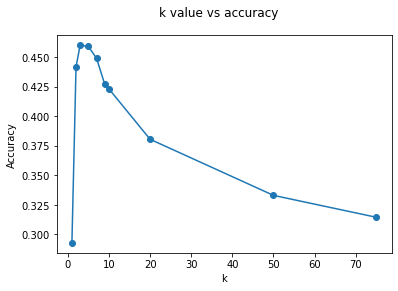

In [ ]:
# find optimal k value
k_vals = [1, 2, 3, 5, 7, 9, 10, 20, 50, 75]
r2 = []

for k in k_vals:
  knn = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  r2.append(metrics.r2_score(y_test, y_pred))

print(r2)

plt.plot(k_vals, r2, marker='o')
plt.xlabel('k')
plt.ylabel('R2')
plt.suptitle('k value vs R2')
plt.show()

In [ ]:
# try svr model with various kernels, C and epsilon values
regr = SVR(C=1.0, epsilon=0.2)
regr.fit(X_train, y_train)
regression_results(y_test, regr.predict(X_test))

explained_variance:  0.0015
r2:  -0.1439
MAE:  131962.7377
MSE:  45130980873.221
RMSE:  212440.5349
explained_variance:  0.0015
r2:  -0.1439
MAE:  131962.7377
MSE:  45130980873.221
RMSE:  212440.5349


In [ ]:
regr = SVR(C=0.5, epsilon=0.2)
regr.fit(X_train, y_train)
regression_results(y_test, regr.predict(X_test))

explained_variance:  0.0008
r2:  -0.1448
MAE:  132049.8575
MSE:  45165578873.0533
RMSE:  212521.9492


In [ ]:
regr = SVR(C=1.0, epsilon=0.2, kernel='sigmoid')
regr.fit(X_train, y_train)
regression_results(y_test, regr.predict(X_test))

explained_variance:  0.002
r2:  -0.1435
MAE:  131902.5771
MSE:  45113492082.5684
RMSE:  212399.3693


In [ ]:
regr = SVR(C=1.0, epsilon=0.2, kernel='poly')
regr.fit(X_train, y_train)
regression_results(y_test, regr.predict(X_test))

explained_variance:  0.0033
r2:  -0.1424
MAE:  131532.4068
MSE:  45071288460.2155
RMSE:  212299.9964


In [ ]:
regr = SVR(C=1.0, epsilon=0.2, kernel='linear')
regr.fit(X_train, y_train)
regression_results(y_test, regr.predict(X_test))

explained_variance:  0.0314
r2:  -0.1085
MAE:  128357.7195
MSE:  43732099334.7385
RMSE:  209122.2115


In [ ]:
regr = SVR(C=0.1, epsilon=0.8, kernel='linear')
regr.fit(X_train, y_train)
regression_results(y_test, regr.predict(X_test))

explained_variance:  0.0035
r2:  -0.1422
MAE:  131735.7573
MSE:  45062786726.0156
RMSE:  212279.9725


# Download as PDF

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Project3.ipynb')

--2022-03-16 15:34:18--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-03-16 15:34:18 (27.8 MB/s) - ‘colab_pdf.py’ saved [1864/1864]





Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Project3.ipynb to pdf
[NbConvertApp] Support files will be in Project3_files/
[NbConvertApp] Making directory ./Project3_files
[NbConvertApp] Writing 125396 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Ru

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'